# Edinburgh bike counter

Arjan Geers

Analysis of [bike counter data](https://data.edinburghopendata.info/dataset/bike-counter-data-set-cluster) provided by The City of Edinburgh Council.

## Preamble

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import calendar
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from bikecounter.data import get_edinburgh_bike_counter_data

In [3]:
# Plot settings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('seaborn')
TITLE_FONTSIZE = 16

%matplotlib inline

## Get data

Download and read the data of all bike counters.

Each counter has one or more 'channels', which correspond to a cycling direction. The actual direction is not specified in the data, so for now we'll just consider the total count across all channels.

In [4]:
hourly = get_edinburgh_bike_counter_data()
hourly.tail()

,01peffermillroad,02steadfastgate,03hawkhillavenue,04seafieldstreet,05blackhall,06silverknowes,07westercoates,08forthroadbridge,09queensferrydalmeny,10rbsgogar,...,39bruntsfieldplacesouthside,40mayfieldroadnorthbound,41mayfieldroadsouthbound,42melvilledrivemain,43melvilledrivespur,44melvilledrivebus1southbound,45melvilledrivebus2northbound,46fishwivescauseway,47inverleithpark,48creweroadsouth
2016-06-18 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,9.0,8.0,47.0,38.0,13.0,10.0,6.0,13.0,5.0
2016-06-18 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,4.0,4.0,50.0,30.0,9.0,11.0,5.0,6.0,4.0
2016-06-18 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,6.0,2.0,32.0,26.0,7.0,3.0,3.0,2.0,4.0
2016-06-18 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,4.0,0.0,24.0,15.0,7.0,5.0,3.0,4.0,1.0
2016-06-18 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,1.0,15.0,7.0,1.0,1.0,0.0,1.0,6.0


In [5]:
# Define variables for later convenience
daily = hourly.resample('D').sum().replace(0, np.NaN)
counters = list(hourly.columns)
n_counters = len(counters)
n_cols = 5  # for grid plots
n_rows = math.ceil(n_counters / n_cols)  # for grid plots

## Bike counter operating days

When were the bike counters turned on and counting bikes?

In [6]:
def get_datetime_ranges(datetimes, bin_size='D'):
    """Given a list of sorted datetimes, return a list
    of datetime ranges [(start, end), (...)] that
    correspond to periods without gaps at the bin_size
    resolution.
    
    """
    datetime_ranges = []
    start = datetimes[0]
    for i in range(1, len(datetimes)):
        if (datetimes[i].to_period(bin_size) -
            datetimes[i - 1].to_period(bin_size)).n > 1:
            end = datetimes[i - 1]
            datetime_ranges.append((start, end))
            start = datetimes[i]
    end = datetimes[-1]
    datetime_ranges.append((start, end))
    return datetime_ranges

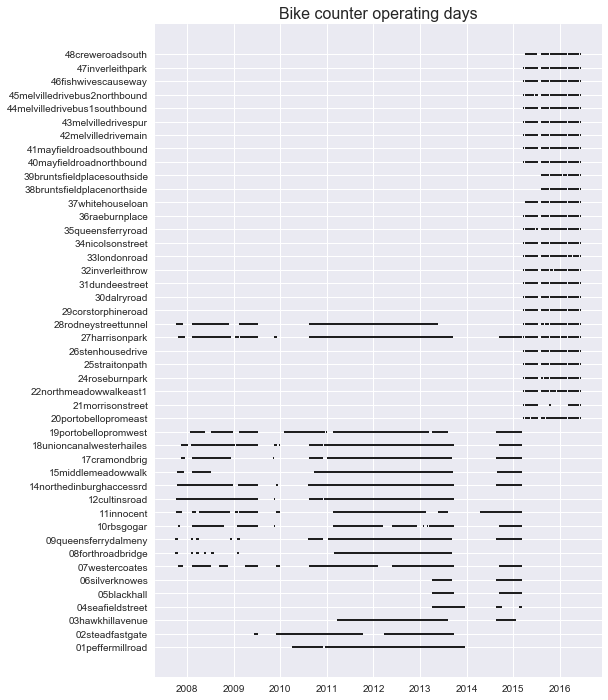

In [7]:
plt.figure(figsize=(8, 12))
for y, counter in enumerate(counters):
    operating_days = daily[counter].dropna().index
    operating_day_ranges = get_datetime_ranges(operating_days, bin_size='D')
    for operating_day_range in operating_day_ranges:
        plt.hlines(y, operating_day_range[0], operating_day_range[1])

plt.title('Bike counter operating days', fontsize=TITLE_FONTSIZE)
plt.yticks(range(n_counters), counters);

We see two distinct sets of bike counters. In early 2015, the first set stopped operating and the second started. Only two bike counters span the entire time period. We also see there are many large and small data gaps.

Are there any days of the week on which the bike counters were operating less (or more)?

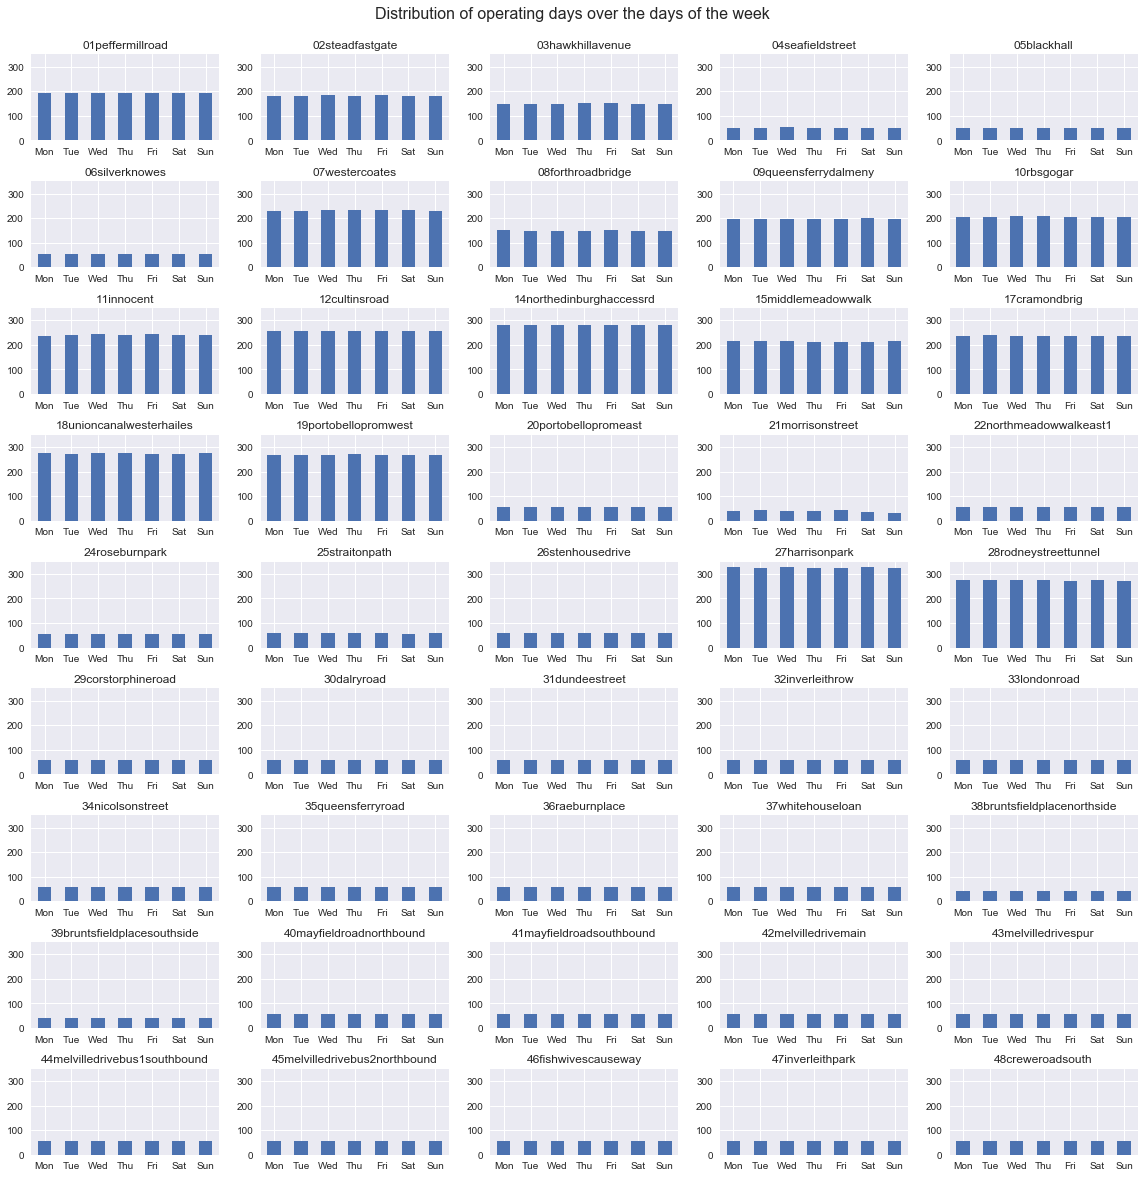

In [8]:
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 16))
for i, counter in enumerate(counters):
    current_ax = ax[i // n_cols][i % n_cols]
    operating_days = daily[counter].dropna().index
    operating_dayofweek_counts = operating_days.dayofweek.value_counts().sort_index()
    operating_dayofweek_counts.plot(ax=current_ax,
                                    kind='bar',
                                    title=counter,
                                    ylim=(0, 350))
    current_ax.set_xticklabels(list(calendar.day_abbr), rotation=0);
    
fig.suptitle('Distribution of operating days over the days of the week', y=1.02, fontsize=TITLE_FONTSIZE)
plt.tight_layout()

All days appear to be equally represented in the dataset. This means we can just average over all available data to look at hourly and daily trends.

## Hourly and daily trends

Let's look at the hourly trend first.

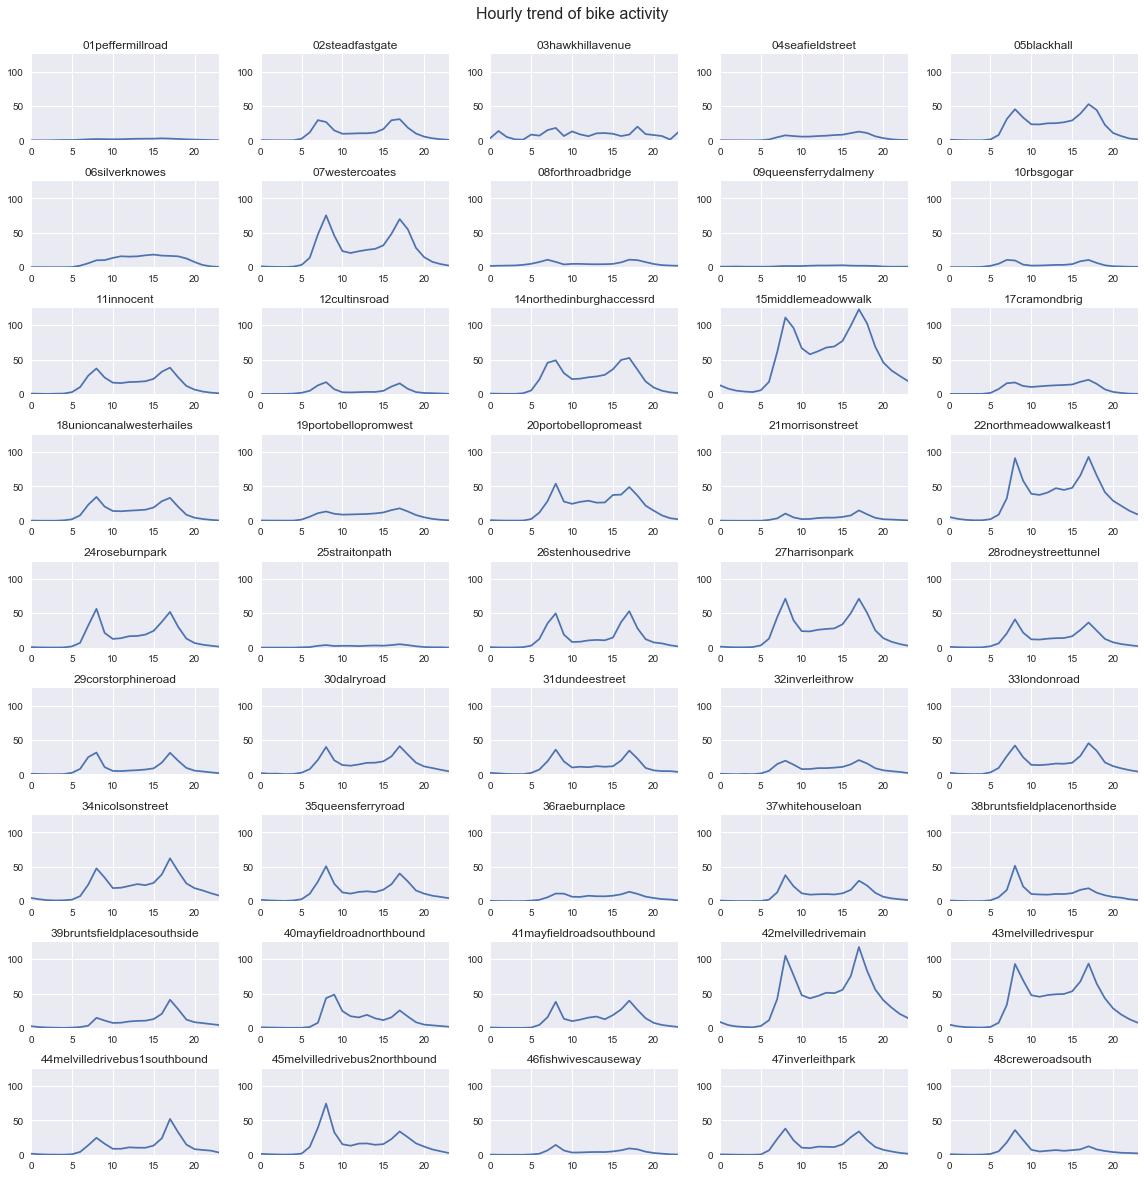

In [9]:
hourly_trend = hourly.groupby(hourly.index.hour).mean()

fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 16))
for i, counter in enumerate(counters):
    current_ax = ax[i // n_cols][i % n_cols]
    hourly_trend[counter].plot(ax=current_ax,
                               title=counter,
                               ylim=(0, 125))
    
fig.suptitle('Hourly trend of bike activity', y=1.02, fontsize=TITLE_FONTSIZE)
plt.tight_layout()

By keeping the limits of the y-axis the same, we can easily see that some roads are much busier than others. Nearly all roads show a bimodal traffic pattern with a peak in the morning and a peak in the afternoon, corresponding to rush hour. On Bruntsfield Place, the separate counters for the northbound (into the city) and southbound (out of the city) directions show relatively large peaks going into the city in the morning and out of the city in the afternoon, which matches our expectation of commuting flows. If we were to look further into cycling direction, we would have to consider the bike counter channels separately and 'guess' the direction.

How about the daily trend?

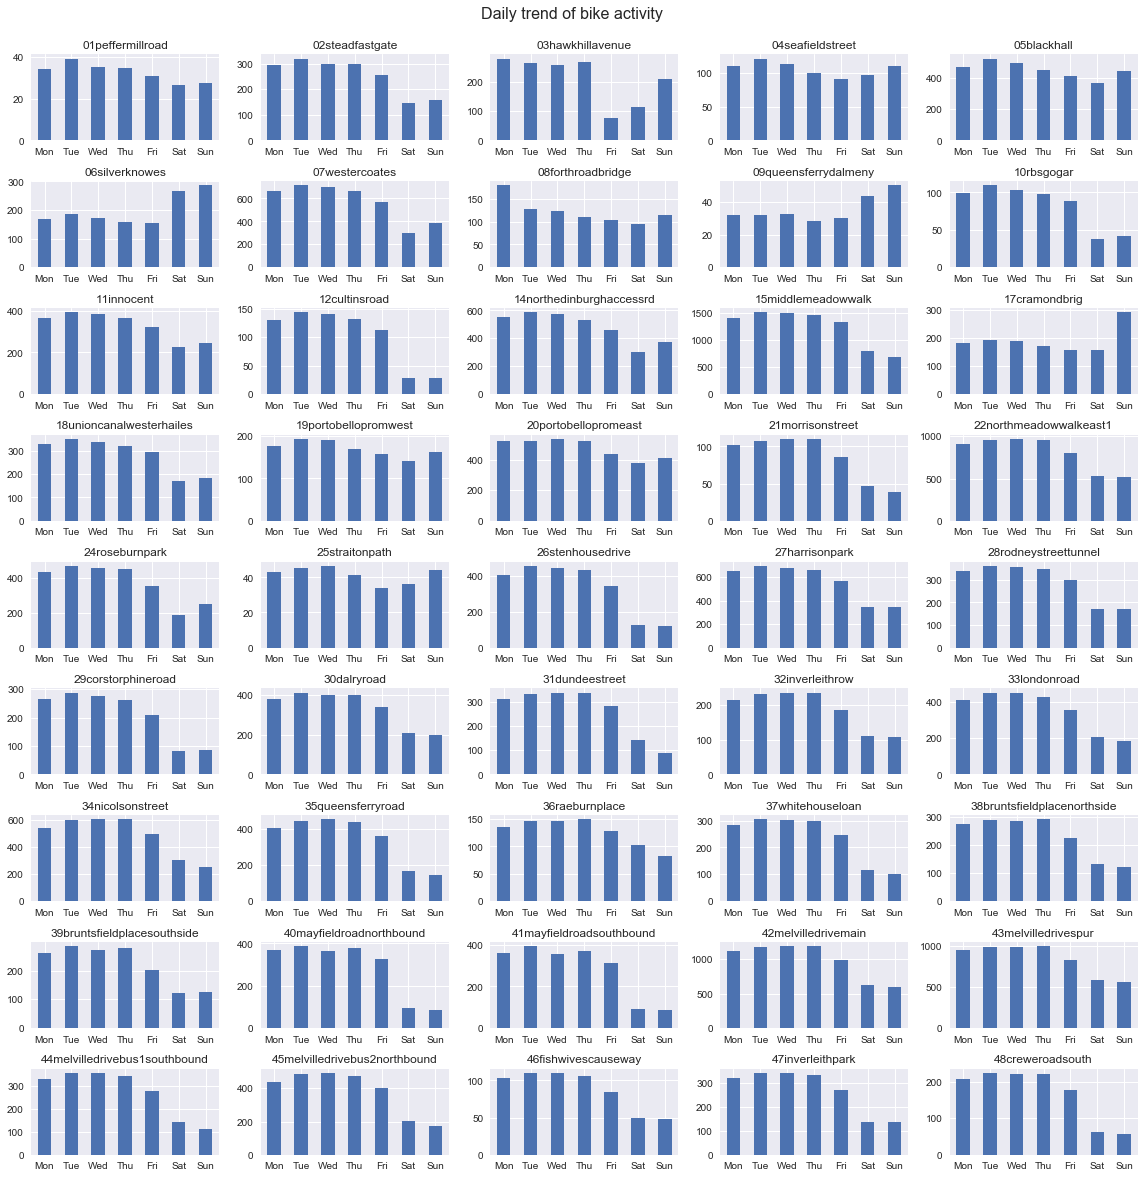

In [10]:
daily_trend = daily.groupby(daily.index.dayofweek).mean()

fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 16))
for i, counter in enumerate(counters):
    current_ax = ax[i // n_cols][i % n_cols]
    daily_trend[counter].plot(ax=current_ax,
                              kind='bar',
                              title=counter)
    current_ax.set_xticklabels(list(calendar.day_abbr), rotation=0);
    
fig.suptitle('Daily trend of bike activity', y=1.02, fontsize=TITLE_FONTSIZE)
plt.tight_layout()

Note that we use flexible y-axis limits to highlight the relative variation throughout the week. We see that for most counters the bike activity is much higher on weekdays than in the weekend. Silverknowes, Cramond, and Dalmeny - in a lovely area to the northwest of Edinburgh - are more popular with cyclists in the weekend. 

## Unsupervised clustering

In this section, we will closely follow the approach described by [Jake Vanderplas](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) to cluster days for one of the bike counters. The example we'll pick is from Portobello Promenade, a cycle path along the beach that I occasionally used to get to and from work.

Note that we'll reuse some of the variable names in the code. `hourly` will from now on contain data of only one counter instead of all of them.

In [11]:
COUNTER_NAME = '20portobellopromeast'

hourly_all = hourly.copy()  # keep original dataset with all counters
hourly = pd.DataFrame(hourly_all[COUNTER_NAME].dropna())

First we transform the data to a 2D matrix with days as rows and hours as columns.

In [12]:
hourly_pivoted = hourly.pivot_table(index=hourly.index.date,
                                    columns=hourly.index.hour,
                                    fill_value=0)
X = hourly_pivoted.values

We then reduce the dimensionality of the matrix from 24 to 2 using principal component analysis (PCA), which will allow us to create a scatter plot and visually look for clusters. As you can see below, the 2 components we get still preserve 81% of the variance in the dataset.

In [13]:
n_components = 2
pca = PCA(n_components)
Xpca = pca.fit_transform(X)
print(f'Preserved variance with {n_components} components: {pca.explained_variance_ratio_.sum():.3f}')

Preserved variance with 2 components: 0.813


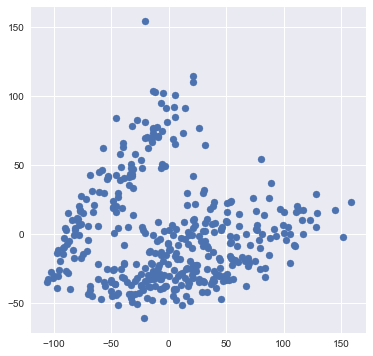

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(Xpca[:, 0], Xpca[:, 1]);

Looks like the days can be nicely split in two clusters. We'll use a Gaussian Mixture model to automatically label the points.

In [15]:
gmm = GaussianMixture(2, covariance_type='full', random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)

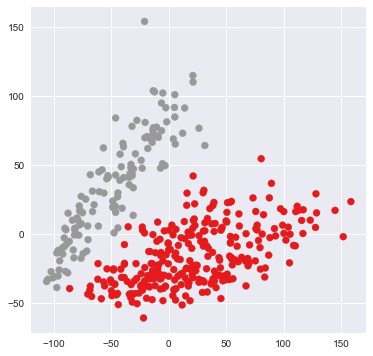

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label, cmap='Set1');

Not bad! The red points belong to cluster 0, the gray ones to cluster 1. Let's see what the hourly trends look like for the two clusters.  

In [17]:
hourly_pivoted['cluster'] = cluster_label
hourly_labeled = hourly.join(hourly_pivoted['cluster'], on=hourly.index.date)
hourly_trend = hourly_labeled.groupby(['cluster', hourly_labeled.index.hour]).mean()

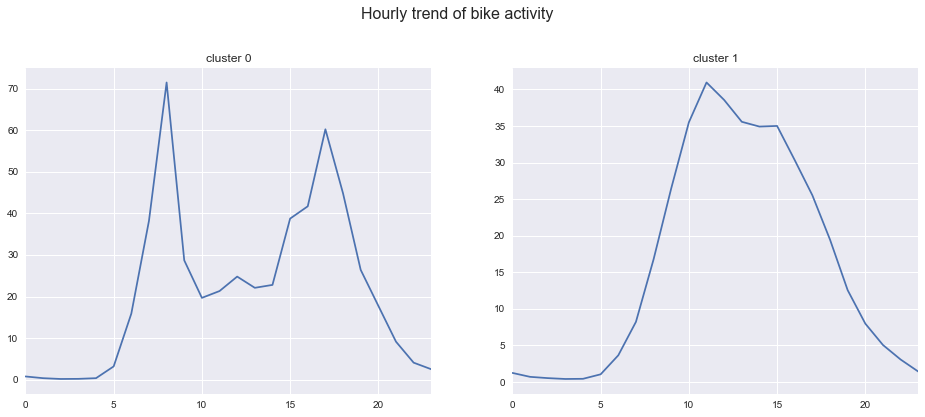

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
for i in range(2):
    hourly_trend.loc[i].plot(ax=ax[i], legend=False)
    ax[i].set_title(f'cluster {i}')
fig.suptitle('Hourly trend of bike activity', y=1.02, fontsize=TITLE_FONTSIZE);

Nice! Cluster 0 shows the typical commuting flows from weekdays while cluster 1 shows the more recreational cycling you'd expect to see in the weekend. We can confirm this by coloring the scatter plot points by day of the week... 

In [19]:
hourly_pivoted['dayofweek'] = pd.to_datetime(hourly_pivoted.index).dayofweek
hourly_pivoted['is_weekend'] = hourly_pivoted['dayofweek'] > 4

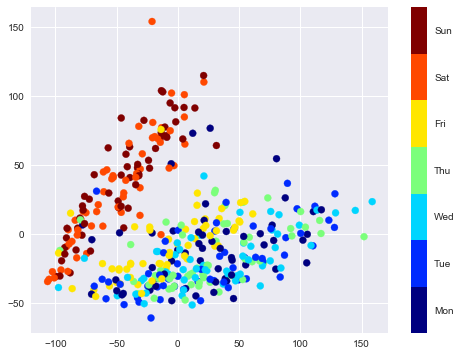

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=hourly_pivoted['dayofweek'],
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);

... or counting the number of weekdays and weekend days within each cluster.

In [21]:
hourly_pivoted.groupby(['cluster', 'is_weekend']).size()

cluster  is_weekend
0        False         271
         True            1
1        False          14
         True          113
dtype: int64

The weekdays in the 'weekend-like' cluster 1 are likely holidays. But there are two days I'd like to look further into:
1. The only weekend day in the 'weekday-like' cluster 0
2. The weekend day outlier at the top of the scatter plot

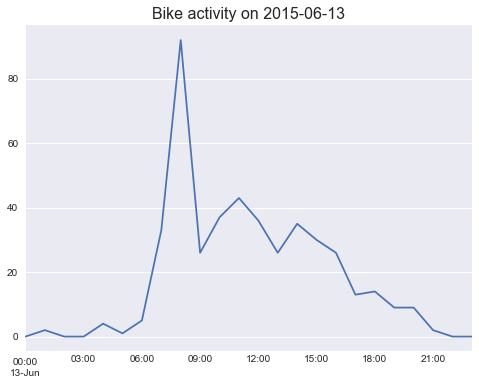

In [22]:
weekend_day_in_cluster_0 = hourly_pivoted.loc[(hourly_pivoted['cluster'] == 0) &
                                              hourly_pivoted['is_weekend']].index.astype(str)[0]

hourly[weekend_day_in_cluster_0].plot(figsize=(8, 6), legend=False)
plt.title(f'Bike activity on {weekend_day_in_cluster_0}', fontsize=TITLE_FONTSIZE);

Morning rush hour on a Saturday! [Looks like](http://markusstitz.com/capital-trail/) we caught the start of the inaugural ride of the Capital Trail, a two-day bikepacking route near Edinburgh. Not your usual morning commute.

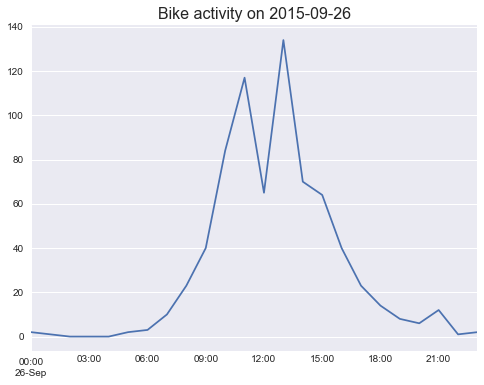

In [23]:
weekend_day_outlier = hourly_pivoted.index[(Xpca[:, 1] > 150)].astype(str)[0]

hourly[weekend_day_outlier].plot(figsize=(8, 6), legend=False)
plt.title(f'Bike activity on {weekend_day_outlier}', fontsize=TITLE_FONTSIZE);

That's a lot more cyclists than usual for cluster 1. It's not much to go by, but [this page](https://www.edinburghbiketours.co.uk/EBT/node/2916/contact) on Edinburgh bike tours says "City Centre Holyrood Park Portobello Guided Tour on Saturday, 26th September 2015 (10:30)". Guess that explains it!